### Carga de Librerias

In [1]:
pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 13.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 3.2. Recopilación y descripción de Datos

Primeras filas del dataset:
   Solicitud Fch Ingreso Tipo Cliente  Puntaje_Obtenido Cliente Tipo Id  \
0      88053  2001-12-31     Individu             93.25     cl1       C   
1      93520  2002-01-16     Individu             92.60     cl2       C   
2     100220  2002-02-04     Individu             92.45     cl3       C   
3     106157  2002-02-27     Individu             92.45     cl4       C   
4      78259  2001-12-17     Individu             92.35     cl5       C   

  Idenficación              Fch Nac Ect Civil Nacionalidad  ... Valor Punto  \
0          id1  1959-10-16 00:00:00         C          ECU  ...           7   
1          id2  1952-12-08 00:00:00         C          ECU  ...           6   
2          id3  1962-09-16 00:00:00         C          ECU  ...           6   
3          id4  1940-08-06 00:00:00         C          ECU  ...           5   
4          id5  1964-09-08 00:00:00         C          ECU  ...           7   

                Plan Sugerido Garantia Sugerid

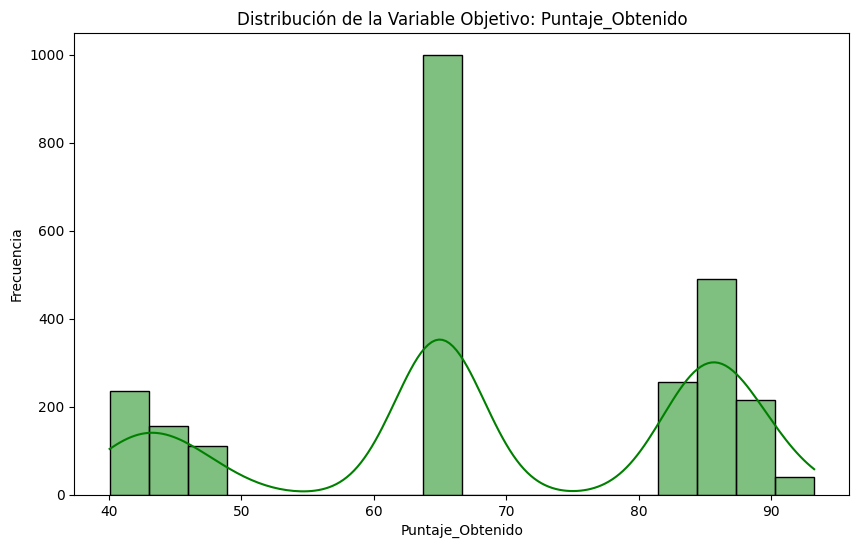

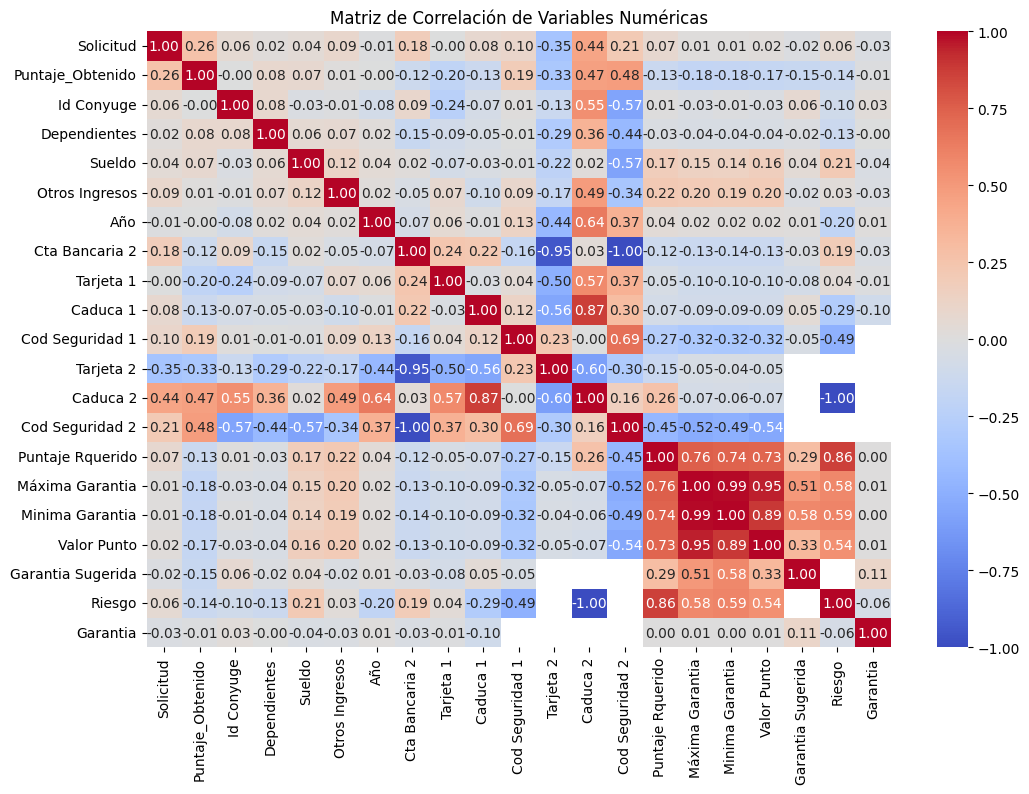

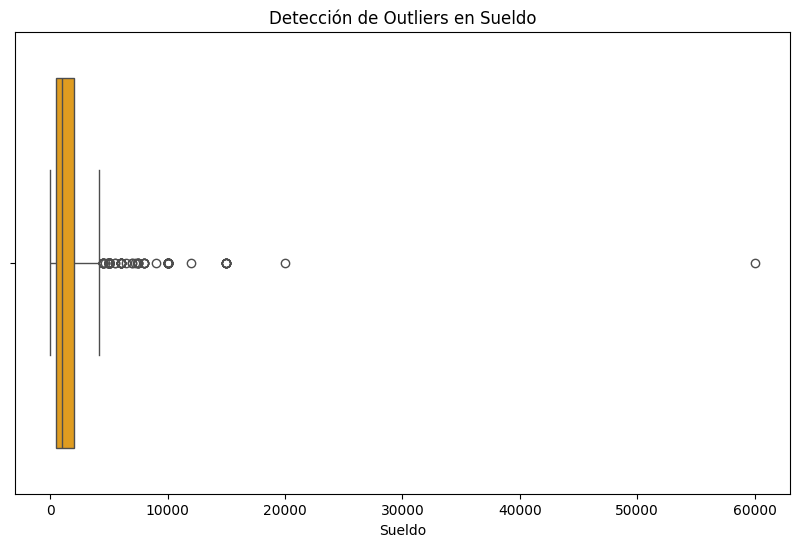

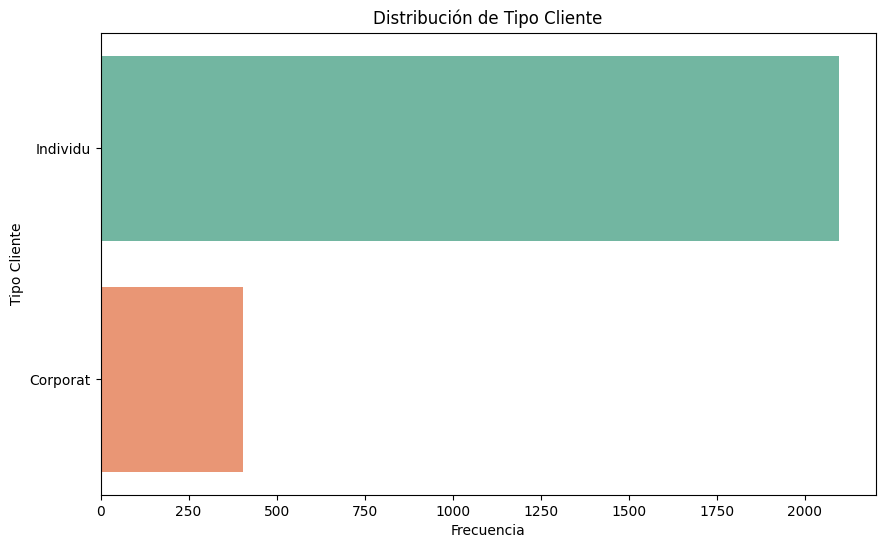

In [ ]:
# 1. Recopilación de Datos
# Cargar los datos desde el archivo Excel en Google Drive
file_path = '/content/drive/My Drive/TFM/Clientes_CS.xlsx'
data = pd.read_excel(file_path)

# Ver las primeras filas del dataset
print("Primeras filas del dataset:")
print(data.head())

# Información general y tipos de datos
print("\nInformación general y tipos de datos:")
print(data.info())

# 1.1 Distribución de la Variable Objetivo (Puntaje_Obtenido)
if 'Puntaje_Obtenido' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data['Puntaje_Obtenido'], kde=True, color='green')
    plt.title('Distribución de la Variable Objetivo: Puntaje_Obtenido')
    plt.xlabel('Puntaje_Obtenido')
    plt.ylabel('Frecuencia')
    plt.show()

# 1.2 Matriz de Correlación entre Variables Numéricas
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 8))
correlation_matrix = data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

# 1.3 Gráfico de Caja (Boxplot) para Detectar Outliers en una Variable Numérica Clave (Sueldo)
if 'Sueldo' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data['Sueldo'], color='orange')  # Cambiado a 'Sueldo'
    plt.title(f'Detección de Outliers en Sueldo')
    plt.show()

# 1.4 Distribución de una Variable Categórica Importante
categorical_cols = data.select_dtypes(include=['object']).columns
plt.figure(figsize=(10, 6))
sns.countplot(y=data[categorical_cols[0]], hue=data[categorical_cols[0]], palette='Set2',
              order=data[categorical_cols[0]].value_counts().index, legend=False)
plt.title(f'Distribución de {categorical_cols[0]}')
plt.xlabel('Frecuencia')
plt.ylabel(categorical_cols[0])
plt.show()

### 3.3. Preparación y Procesamiento de Datos


Valores faltantes por columna:
Idenficación                1
Fch Nac                   312
Ect Civil                 404
Nacionalidad              404
Sexo                      404
Id Conyuge               2195
Dependientes              404
Sector                    404
Ciudad                      4
Canton                    812
Telefono                  396
Telf Dom 1                  7
Ciudad 1                   24
Profesión                   2
Orig Otros Ingresos      1121
Tipo Residencia           404
Nombre Tarjeta           1276
Nombre Banco             1396
Tipo Cuenta              1396
Cta Bancaria             1396
Empresa Anterior         2337
EAN Cargo                2337
EAN Tiempo               2337
Empresa Actual              1
EAC Tiempo                  1
EAC Telefono              488
EAC Actividad               1
EAC NomRepLeg            2077
Marca                    1977
Año                      1981
Placa                    1981
Ref Bancaria 1           1762
Cta Banc

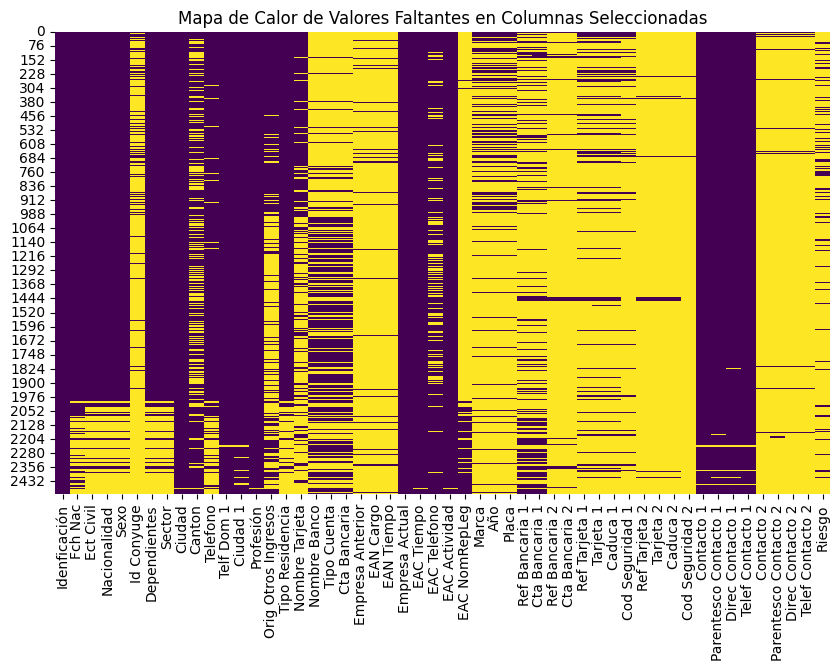

Número de columnas antes
25118
Número de columnas después
293


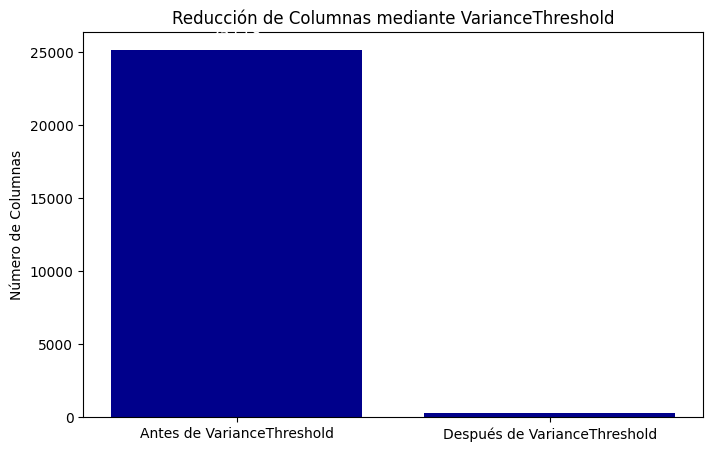

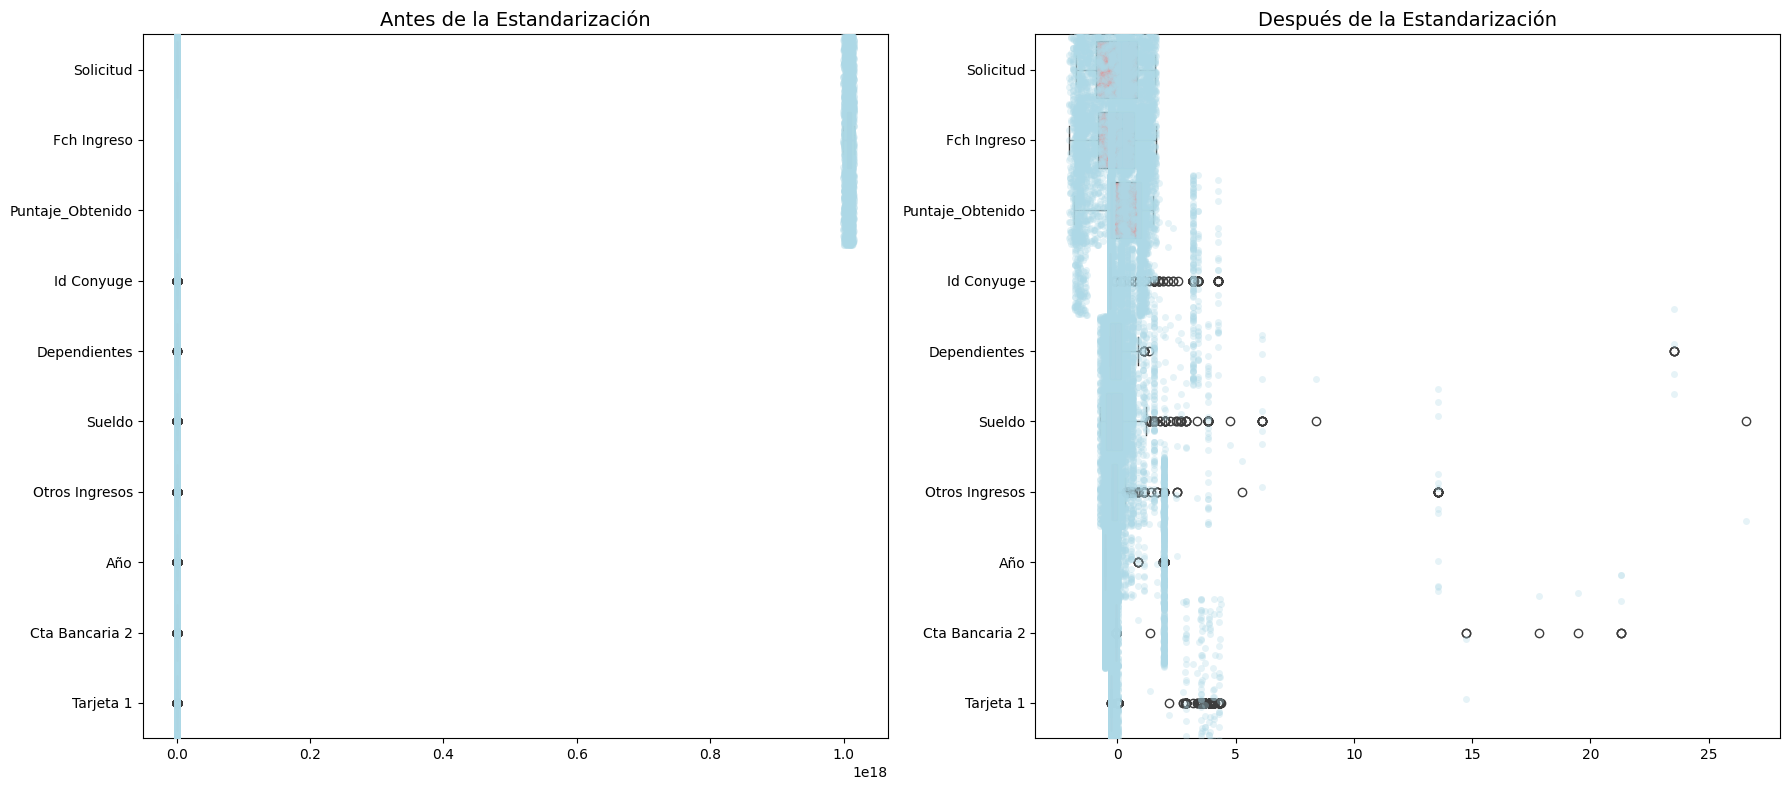

In [ ]:
# Verificar valores faltantes
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]

if not missing_values.empty:
    print("\nValores faltantes por columna:")
    print(missing_values)

    # Visualización de valores faltantes solo para columnas con valores faltantes
    plt.figure(figsize=(10, 6))
    sns.heatmap(data[missing_values.index].isnull(), cbar=False, cmap='viridis')
    plt.title("Mapa de Calor de Valores Faltantes en Columnas Seleccionadas")
    plt.show()
else:
    print("\nNo hay columnas con valores faltantes.")

# Variables categóricas, usar pd.get_dummies() para convertirlas en numéricas
data_transformed = pd.get_dummies(data)

# Reducción del número de columnas usando un umbral de varianza
data_transformed = data_transformed.apply(pd.to_numeric, errors='coerce')
data_transformed = data_transformed.fillna(0)  # O un valor apropiado para imputar

# Elimina características con varianza baja
selector = VarianceThreshold(threshold=0.01)
data_reduced = selector.fit_transform(data_transformed)

# Obtener las columnas seleccionadas si necesitas reconstruir un DataFrame
columns_selected = data_transformed.columns[selector.get_support(indices=True)]
data_reduced_df = pd.DataFrame(data_reduced, columns=columns_selected)

# Número de columnas antes y después de VarianceThreshold
columns_before = len(data_transformed.columns)
columns_after = len(data_reduced_df.columns)
print("Número de columnas antes")
print (columns_before)
print("Número de columnas después")
print (columns_after)

# Gráfico de barras mostrando el número de columnas antes y después de la reducción
plt.figure(figsize=(8, 5))
bars = plt.bar(['Antes de VarianceThreshold', 'Después de VarianceThreshold'],
               [columns_before, columns_after], color='darkblue')

# Añadir el número exacto de columnas en la parte superior de las barras
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # 5 puntos de desplazamiento vertical
                 textcoords="offset points",
                 ha='center', va='bottom', color='white', fontsize=12)

plt.title('Reducción de Columnas mediante VarianceThreshold')
plt.ylabel('Número de Columnas')
plt.show()

# Estandarización de datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_reduced_df)

# Convertir el resultado de nuevo a un DataFrame si es necesario
data_final = pd.DataFrame(data_scaled, columns=columns_selected)

# Seleccionar solo las 10 primeras características
data_reduced_df_top10 = data_reduced_df.iloc[:, :10]
data_final_top10 = data_final.iloc[:, :10]

# Ajustar la figura para que las etiquetas se aprecien mejor
plt.figure(figsize=(18, 8))

# Antes de la estandarización
plt.subplot(1, 2, 1)
sns.boxplot(data=data_reduced_df_top10, orient='h', color='lightblue')
sns.stripplot(data=data_reduced_df_top10, orient='h', color='lightblue', alpha=0.3, jitter=1.5)
plt.title('Antes de la Estandarización', fontsize=14)
plt.xticks(color='black')
plt.yticks(color='black')

# Después de la estandarización
plt.subplot(1, 2, 2)
sns.boxplot(data=data_final_top10, orient='h', color='lightcoral')
sns.stripplot(data=data_final_top10, orient='h', color='lightblue', alpha=0.3, jitter=1.5)
plt.title('Después de la Estandarización', fontsize=14)
plt.xticks(color='black')
plt.yticks(color='black')

plt.tight_layout()
plt.show()

### 3.4. Análisis Exploratorio de Datos


Estadísticas Descriptivas del Conjunto de Datos:
          Solicitud   Fch Ingreso  Puntaje_Obtenido   Id Conyuge  \
count  2.500000e+03  2.500000e+03      2.500000e+03  2500.000000   
mean   2.728484e-16 -2.273737e-17     -9.094947e-17     0.000000   
std    1.000200e+00  1.000200e+00      1.000200e+00     1.000200   
min   -1.760025e+00 -2.040812e+00     -1.821060e+00    -0.324618   
25%   -9.193289e-01 -8.389106e-01     -2.800836e-01    -0.324618   
50%    1.550038e-01  1.972113e-01     -2.487629e-01    -0.324618   
75%    8.103612e-01  7.152722e-01      9.840180e-01    -0.324618   
max    1.583515e+00  1.647782e+00      1.511458e+00     4.262520   

       Dependientes        Sueldo  Otros Ingresos           Año  \
count  2.500000e+03  2.500000e+03    2.500000e+03  2.500000e+03   
mean  -4.547474e-17 -4.547474e-17    5.684342e-18  9.094947e-17   
std    1.000200e+00  1.000200e+00    1.000200e+00  1.000200e+00   
min   -3.299806e-01 -7.169916e-01   -2.356715e-01 -5.113587e-01   
25

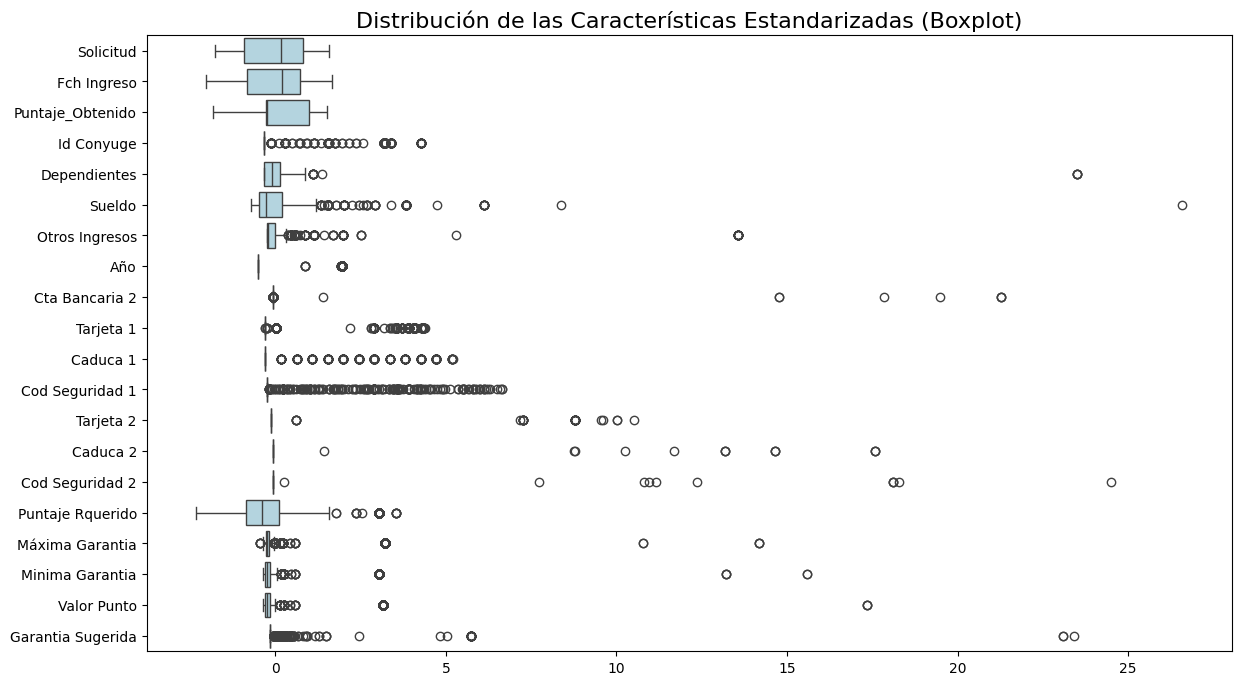

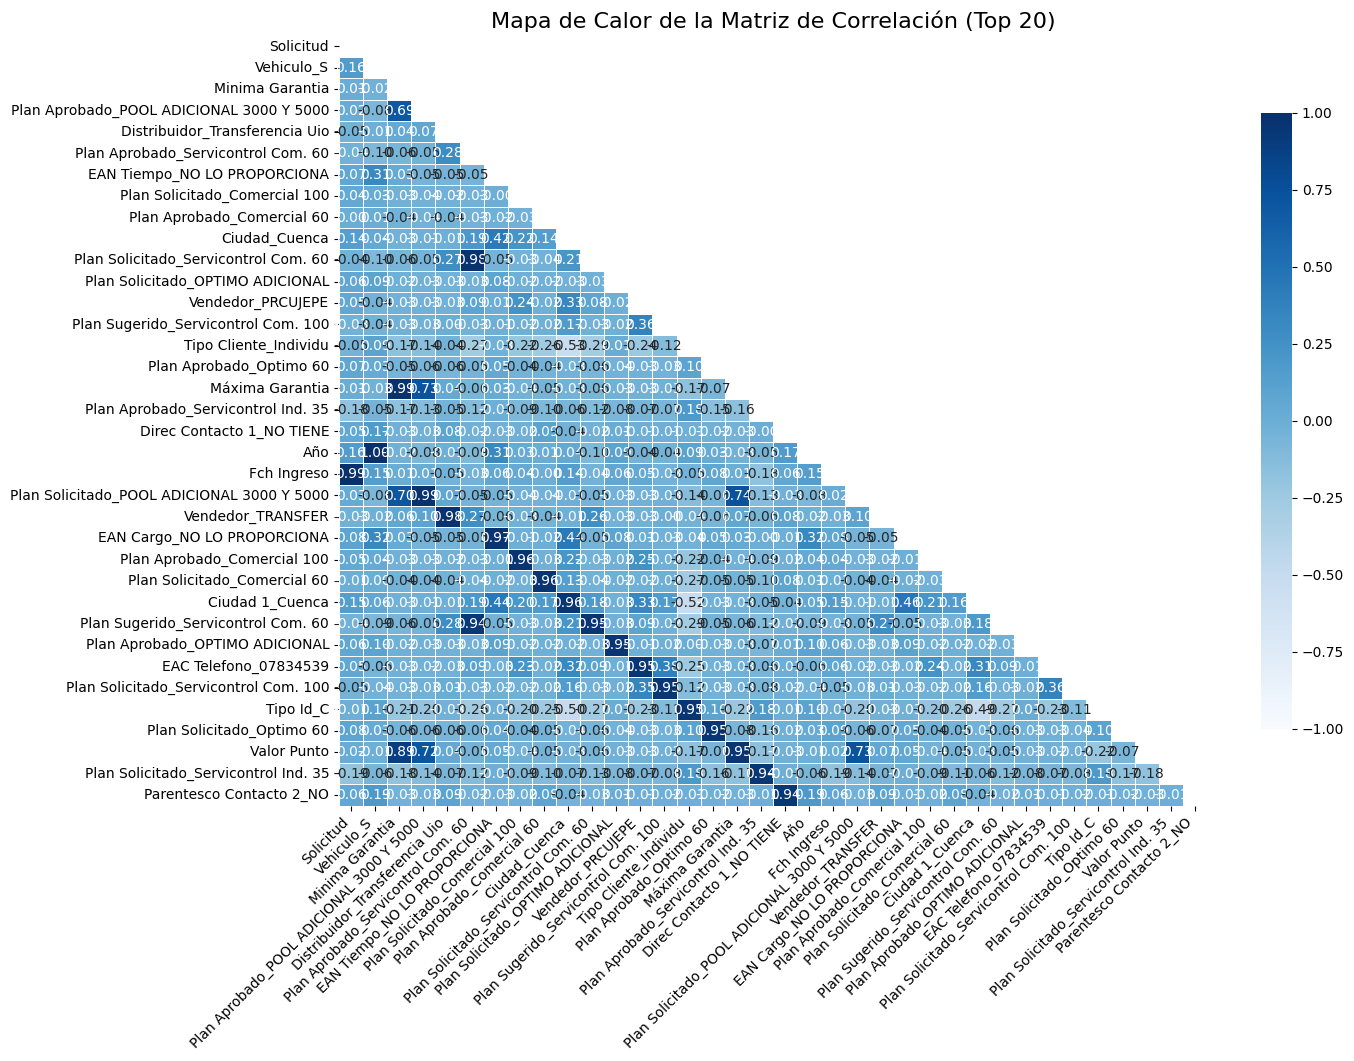

In [ ]:
# Calcular las estadísticas descriptivas del conjunto de datos estandarizado
descriptive_stats = data_final.describe()

# Mostrar las estadísticas descriptivas
print("\nEstadísticas Descriptivas del Conjunto de Datos:")
print(descriptive_stats)

# Visualización de la distribución de las primeras 20 características (Boxplot)
plt.figure(figsize=(14, 8))
sns.boxplot(data=data_final.iloc[:, :20], orient='h', color='lightblue')
plt.title('Distribución de las Características Estandarizadas (Boxplot)', fontsize=16)
plt.show()

# Calcular la matriz de correlación
correlation_matrix = data_final.corr()

# Seleccionar las 20 características con las correlaciones más significativas
corr_pairs = correlation_matrix.unstack().sort_values(kind="quicksort", key=lambda x: abs(x), ascending=False)
top_corr = corr_pairs.drop_duplicates().nlargest(20).reset_index()

# Obtener los nombres de las características más correlacionadas
top_features = pd.Series(list(top_corr['level_0']) + list(top_corr['level_1'])).unique()

# Crear una matriz de correlación solo con estas características
reduced_corr_matrix = correlation_matrix.loc[top_features, top_features]

# Generar el mapa de calor con colores más claros
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(reduced_corr_matrix, dtype=bool))

sns.heatmap(reduced_corr_matrix, mask=mask, cmap='Blues', annot=True, fmt=".2f", linewidths=0.5, cbar_kws={"shrink": .8}, vmin=-1, vmax=1)
plt.title("Mapa de Calor de la Matriz de Correlación (Top 20)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()





### 3.5. Selección y Justificación de Modelos

In [ ]:
# Separar las características y el objetivo
X = data_transformed.drop('Puntaje_Obtenido', axis=1)
y = data_transformed['Puntaje_Obtenido']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



### Entrenando Modelos

Evaluando Modelos:   0%|          | 0/10 [00:00<?, ?it/s]

Linear Regression - RMSE: 6.5944, R^2: 0.8174


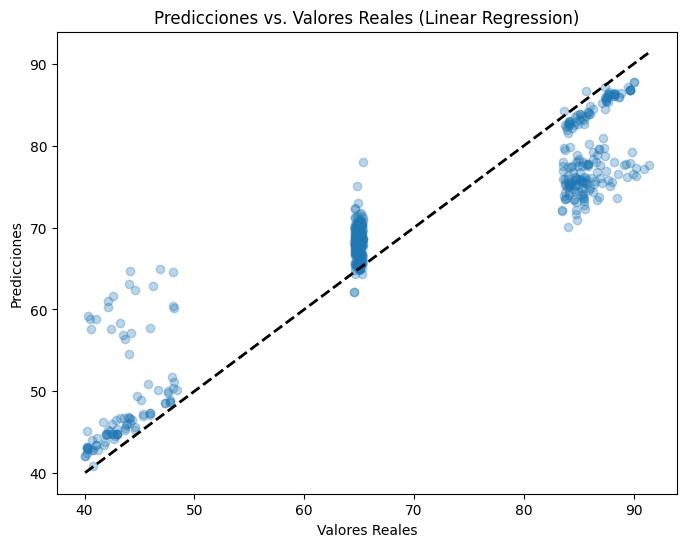

Ridge - RMSE: 6.6052, R^2: 0.8168


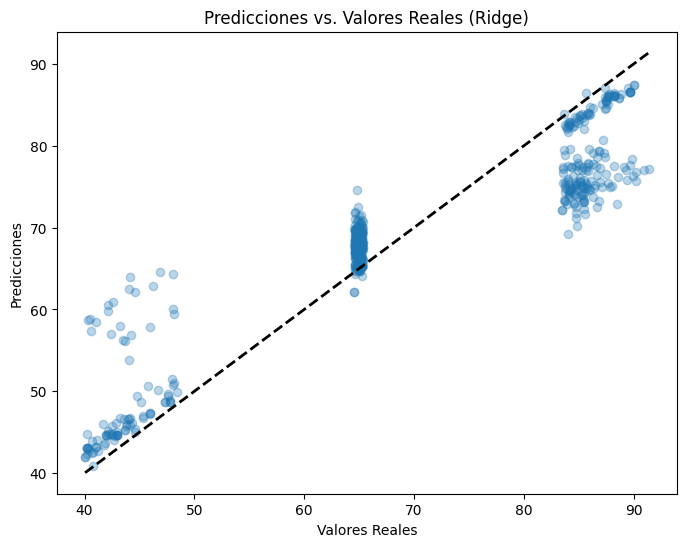

Lasso - RMSE: 4.6729, R^2: 0.9083


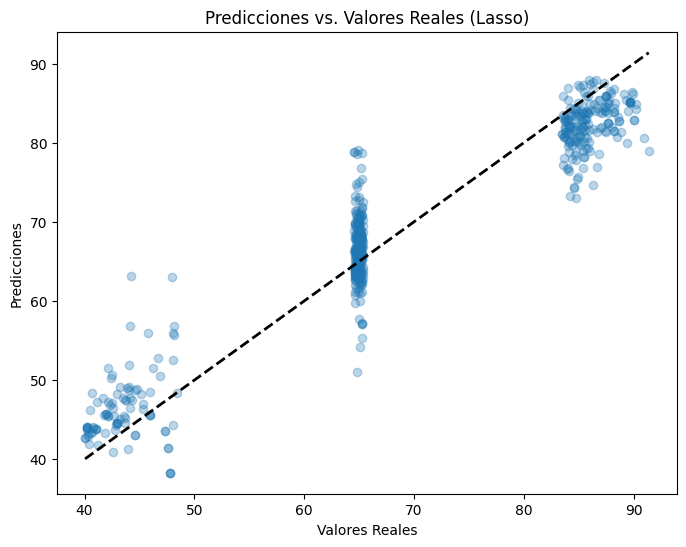

ElasticNet - RMSE: 4.3239, R^2: 0.9215


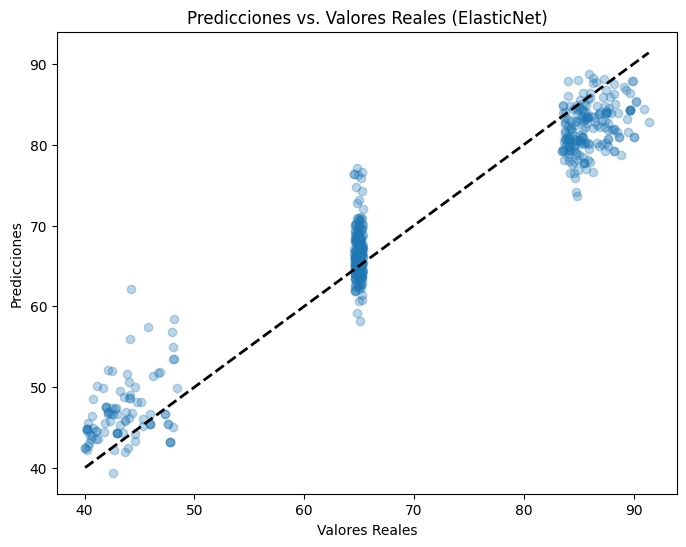

Decision Tree - RMSE: 2.5476, R^2: 0.9728


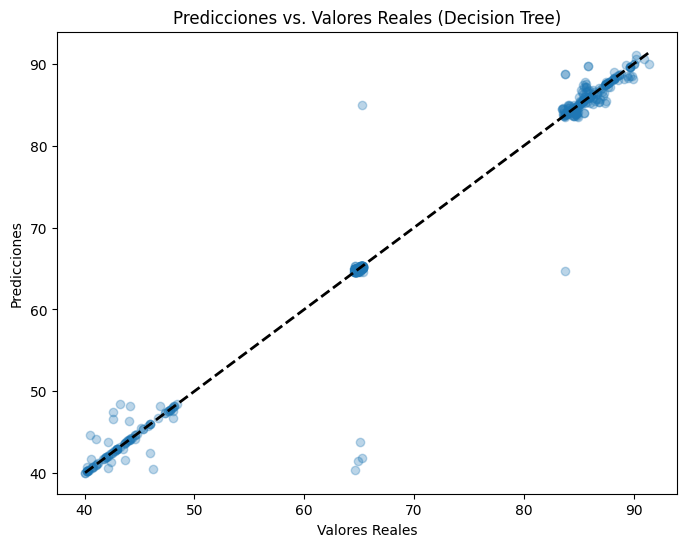

Random Forest - RMSE: 2.2690, R^2: 0.9784


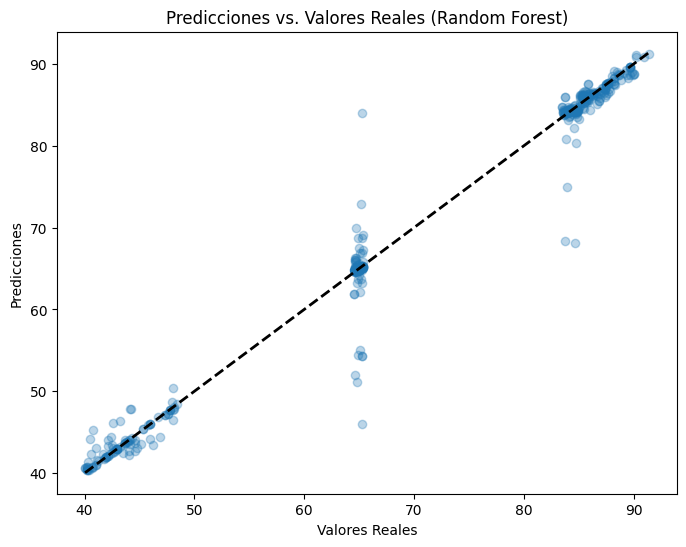

Gradient Boosting - RMSE: 2.1526, R^2: 0.9805


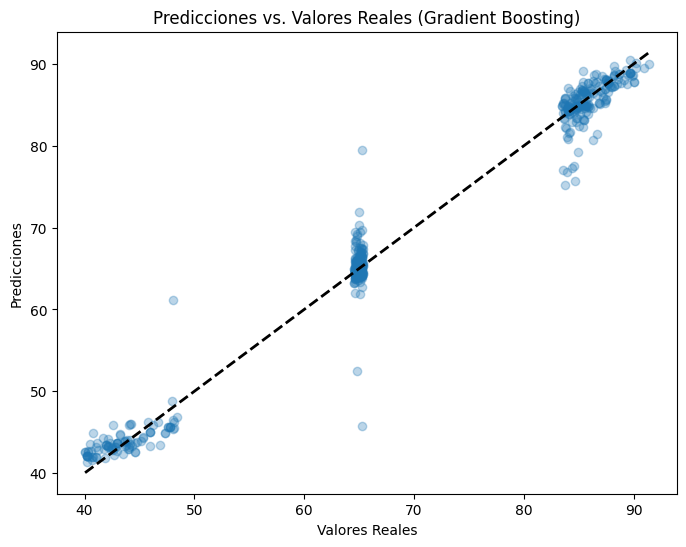

Support Vector Machine - RMSE: 17.4738, R^2: -0.2818


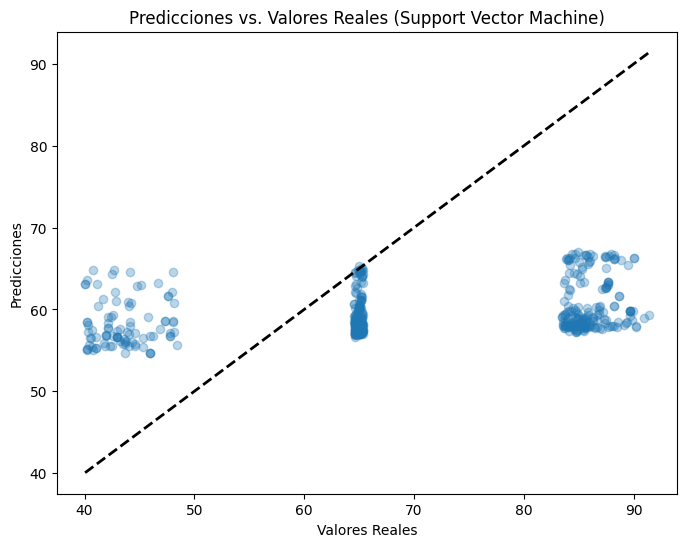

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:43:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - RMSE: 1.7160, R^2: 0.9876


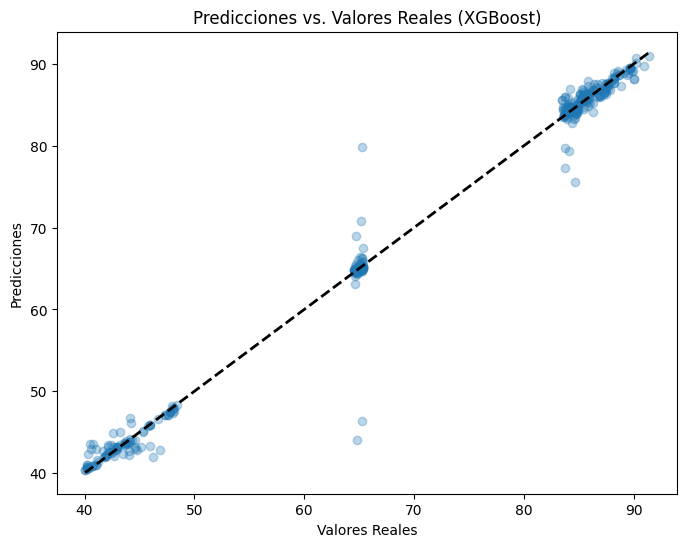

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1734
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 298
[LightGBM] [Info] Start training from score 69.179960
LightGBM - RMSE: 2.0409, R^2: 0.9825


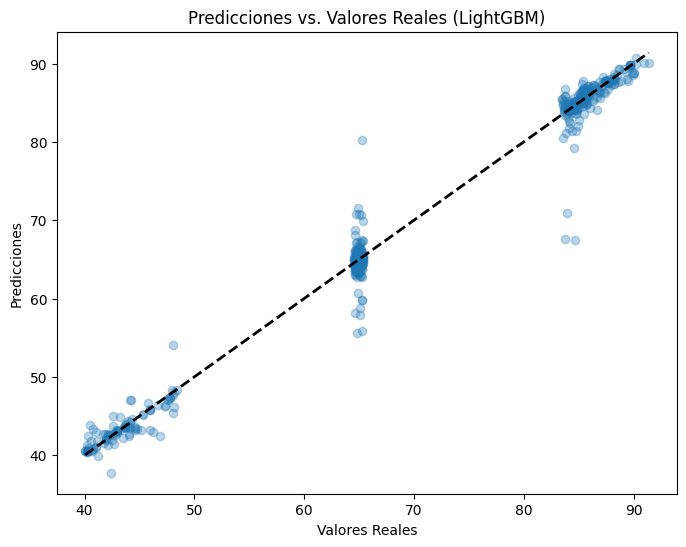

El mejor modelo es XGBoost. Los resultados se han guardado en la carpeta 'resultados' en Google Drive.


In [ ]:
# Lista de modelos a probar (sin GPU)
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Machine": SVR(),
    "XGBoost": XGBRegressor(tree_method='hist', use_label_encoder=False),  # Sin GPU
    "LightGBM": LGBMRegressor()  # Sin GPU
}

# Diccionario para almacenar resultados
results = {}
all_predictions = pd.DataFrame()

# Crear directorio para gráficos
plots_dir = "/content/drive/My Drive/TFM/plots"
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# Función para crear gráfico de predicciones vs valores reales
def plot_predictions_vs_actuals(y_test, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel("Valores Reales")
    plt.ylabel("Predicciones")
    plt.title(f"Predicciones vs. Valores Reales ({model_name})")
    plt.savefig(os.path.join(plots_dir, f"pred_vs_real_{model_name}.png"))
    plt.show()

# Entrenar y evaluar cada modelo
for name, model in tqdm(models.items(), desc="Evaluando Modelos"):
    try:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        results[name] = (rmse, r2)
        print(f"{name} - RMSE: {rmse:.4f}, R^2: {r2:.4f}")

        # Guardar predicciones en un DataFrame
        all_predictions[f"{name}_Pred"] = y_pred

        # Crear gráfico de predicciones vs valores reales
        plot_predictions_vs_actuals(y_test, y_pred, name)

    except Exception as e:
        print(f"Error entrenando el modelo {name}: {e}")

# Seleccionar el mejor modelo basado en RMSE más bajo
best_model_name = min(results, key=lambda x: results[x][0])
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)

print(f"El mejor modelo es {best_model_name}. Los resultados se han guardado en la carpeta 'resultados' en Google Drive.")


### Tabla de Resultados

                   Modelo       RMSE        R²
0       Linear Regression   6.594421  0.817442
1                   Ridge   6.605173  0.816846
2                   Lasso   4.672892  0.908332
3              ElasticNet   4.323880  0.921513
4           Decision Tree   2.547634  0.972753
5           Random Forest   2.268999  0.978387
6       Gradient Boosting   2.152557  0.980548
7  Support Vector Machine  17.473767 -0.281803
8                 XGBoost   1.716009  0.987638
9                LightGBM   2.040871  0.982514


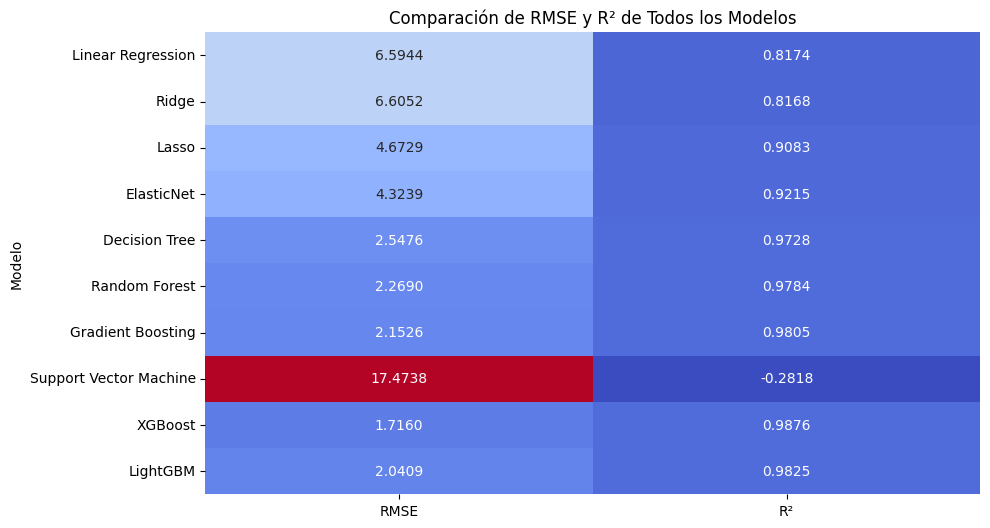

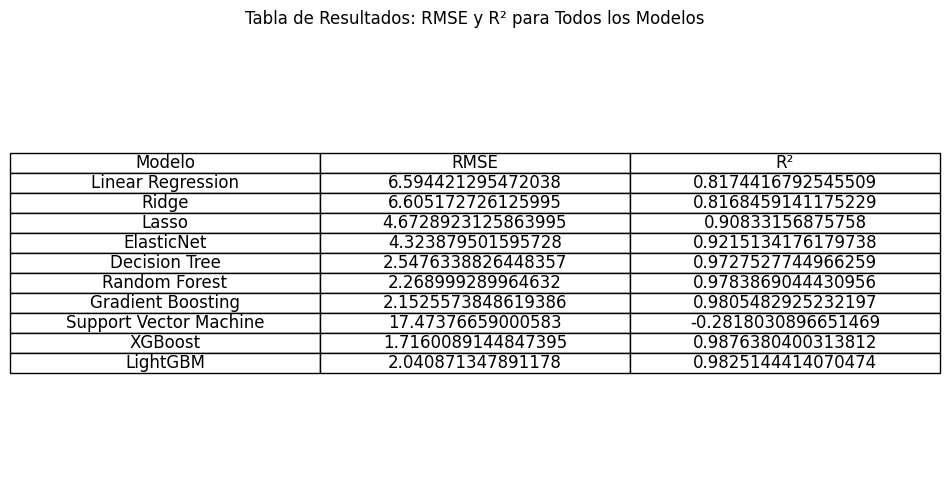

In [ ]:
# Crear un DataFrame a partir de los resultados
results_df_all_models = pd.DataFrame(results).T.reset_index()
results_df_all_models.columns = ["Modelo", "RMSE", "R²"]

# Mostrar la tabla en la consola
print(results_df_all_models)

# Visualizar la tabla de resultados usando seaborn para mejor visualización
plt.figure(figsize=(10, 6))
sns.heatmap(results_df_all_models.set_index("Modelo"), annot=True, fmt=".4f", cmap="coolwarm", cbar=False)
plt.title("Comparación de RMSE y R² de Todos los Modelos")
plt.xticks(rotation=0)
plt.show()

# Si prefieres visualizar en formato de tabla simple sin heatmap
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df_all_models.values, colLabels=results_df_all_models.columns, cellLoc = 'center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.title("Tabla de Resultados: RMSE y R² para Todos los Modelos")
plt.show()

### Guardando Datos

In [ ]:
# Guardar resultados en archivos CSV en Google Drive
results_dir = "/content/drive/My Drive/TFM/resultados"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Guardar las predicciones y los valores reales en un archivo CSV
results_df = pd.DataFrame({'Valores Reales': y_test, 'Predicciones': y_pred_best, 'Errores': y_test - y_pred_best})
results_df.to_csv(os.path.join(results_dir, "resultados_modelo.csv"), index=False)

# Guardar los coeficientes del modelo en un archivo CSV si existen
if hasattr(best_model, 'coef_'):
    coef_df = pd.DataFrame({'Variable': X_train.columns, 'Coeficientes': best_model.coef_})
    coef_df.to_csv(os.path.join(results_dir, "coeficientes_modelo.csv"), index=False)

# Guardar los resultados de todos los modelos en un archivo CSV
results_df_all_models = pd.DataFrame(results).T.reset_index()
results_df_all_models.columns = ["Modelo", "RMSE", "R^2"]
results_df_all_models.to_csv(os.path.join(results_dir, "resultados_todos_modelos.csv"), index=False)

# Guardar todas las predicciones en un archivo CSV
all_predictions["Valores Reales"] = y_test.reset_index(drop=True)
all_predictions.to_csv(os.path.join(results_dir, "todas_las_predicciones.csv"), index=False)

### Gráficos

<ipython-input-11-d88c906236c0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="RMSE", y="Modelo", data=results_df_all_models.sort_values(by="RMSE", ascending=True), palette="viridis")
<ipython-input-11-d88c906236c0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="R^2", y="Modelo", data=results_df_all_models.sort_values(by="R^2", ascending=False), palette="viridis")


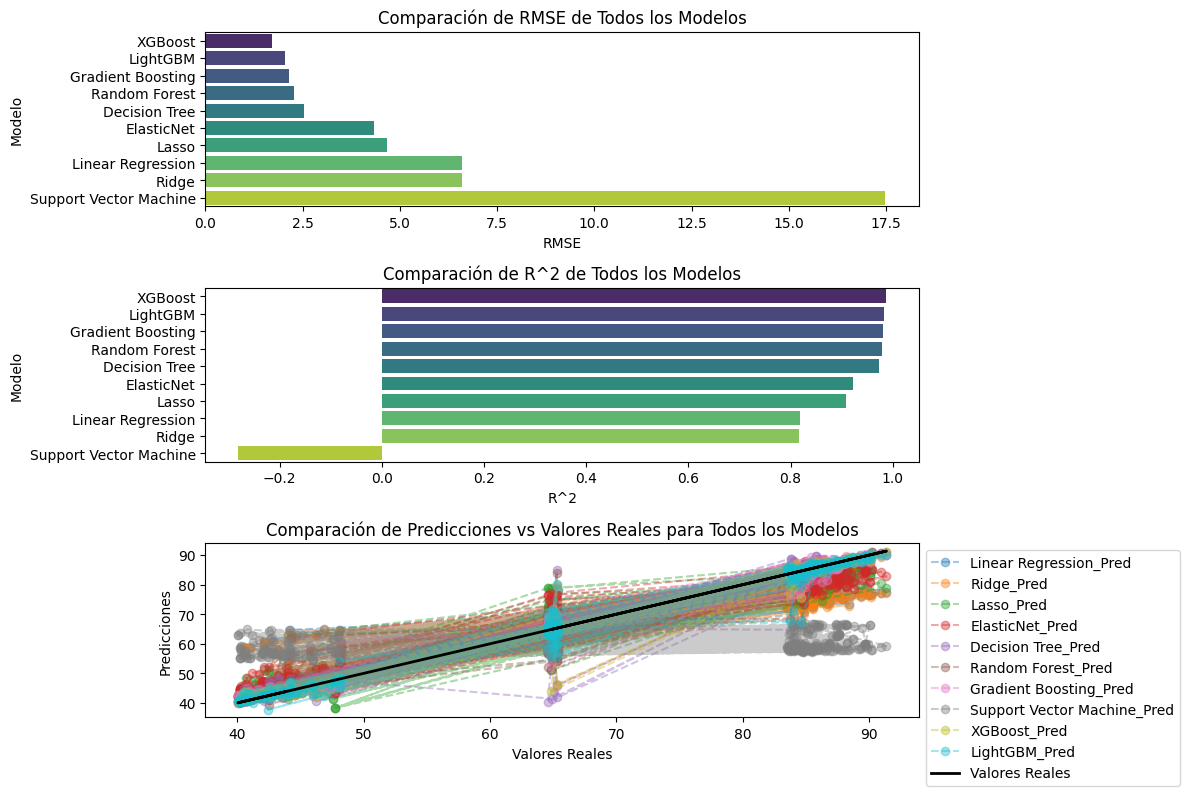

In [ ]:
# Gráfico comparativo de los resultados de todos los modelos
plt.figure(figsize=(12, 8))

# Gráfico de barras para RMSE
plt.subplot(3, 1, 1)
sns.barplot(x="RMSE", y="Modelo", data=results_df_all_models.sort_values(by="RMSE", ascending=True), palette="viridis")
plt.title("Comparación de RMSE de Todos los Modelos")

# Gráfico de barras para R^2
plt.subplot(3, 1, 2)
sns.barplot(x="R^2", y="Modelo", data=results_df_all_models.sort_values(by="R^2", ascending=False), palette="viridis")
plt.title("Comparación de R^2 de Todos los Modelos")

# Gráfico conjunto de predicciones vs valores reales para todos los modelos
plt.subplot(3, 1, 3)
for model_name in all_predictions.columns[:-1]:  # Excluye la columna "Valores Reales"
    plt.plot(y_test.reset_index(drop=True), all_predictions[model_name], linestyle='--', marker='o', alpha=0.4, label=model_name)

plt.plot(y_test.reset_index(drop=True), y_test.reset_index(drop=True), 'k-', lw=2, label="Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Comparación de Predicciones vs Valores Reales para Todos los Modelos")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "comparacion_modelos.png"))
plt.show()
